# ML4T PIPELINE - NOTEBOOK 1: DATA ENGINEERING

## Goal: Fetch, clean, and store OHLCV market data
## Output: market_prices.h5 (saved to Google Drive)


## 01 Data Engineering: The Foundation Layer

This notebook implements the **Data Layer** from the ML4T framework.

**What we do:**
1. Fetch OHLCV data for a universe of stocks
2. Clean data (handle splits/dividends via yfinance's adjusted close)
3. Handle missing values with forward fill
4. Export to HDF5 format for efficient storage

**Output:** `market_prices.h5` → Ready for Alpha Factory (Notebook 2)

## 1. Setup & Configuration

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Google Colab Drive mounting

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = Path('/content/drive/MyDrive/ML4T_Pipeline')
    print("✓ Google Drive mounted successfully")
except:
    DRIVE_PATH = Path('./data')
    print("✓ Running locally - using ./data directory")

# Create directory if it doesn't exist
DRIVE_PATH.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted successfully


## 2. Configuration Parameters

In [ ]:
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',  # Tech giants
    'JPM', 'BAC', 'GS',                        # Financials
    'JNJ', 'PFE',                              # Healthcare
    'XOM', 'CVX'                               # Energy
]

# Time period (6+ years for train/test split)

In [ ]:
START_DATE = '2016-01-01'
END_DATE = '2023-12-31'

In [ ]:
INTERVAL = '1d'  # Daily data

print(f"Configuration:")
print(f"  Tickers: {len(TICKERS)} stocks")
print(f"  Period: {START_DATE} to {END_DATE}")
print(f"  Interval: {INTERVAL}")

Configuration:
  Tickers: 12 stocks
  Period: 2016-01-01 to 2023-12-31
  Interval: 1d


## 3. Data Fetching Function

In [ ]:
def fetch_market_data(tickers, start, end, interval='1d'):
    """
    Fetch OHLCV data for multiple tickers using yfinance.

    Args:
        tickers: List of ticker symbols
        start: Start date (YYYY-MM-DD)
        end: End date (YYYY-MM-DD)
        interval: Data frequency (1d, 1h, etc.)

    Returns:
        DataFrame with MultiIndex (date, ticker) and OHLCV columns
    """
    print(f"\n{'='*60}")
    print(f"Fetching market data for {len(tickers)} tickers...")
    print(f"{'='*60}")

    all_data = []
    failed_tickers = []

    for i, ticker in enumerate(tickers, 1):
        try:
            print(f"[{i}/{len(tickers)}] Downloading {ticker}...", end=' ')

            # Download data
            df = yf.download(
                ticker,
                start=start,
                end=end,
                interval=interval,
                progress=False,
                auto_adjust=True  # Automatic adjustment for splits/dividends
            )

            if df.empty:
                print(f" No data")
                failed_tickers.append(ticker)
                continue

            # Handle MultiIndex columns (yfinance sometimes returns these)
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)

            # Clean column names (convert to lowercase)
            df.columns = [str(col).lower() for col in df.columns]

            # Reset index to make Date a column
            df = df.reset_index()
            df.columns = [str(col).lower() for col in df.columns]

            # Add ticker identifier
            df['ticker'] = ticker

            all_data.append(df)
            print(f"✓ {len(df)} rows")

        except Exception as e:
            print(f" Error: {str(e)[:50]}")
            failed_tickers.append(ticker)

    if not all_data:
        raise ValueError("No data fetched successfully!")

    # Combine all tickers
    combined = pd.concat(all_data, ignore_index=True)

    print(f"\n{'='*60}")
    print(f"✓ Successfully fetched {len(tickers) - len(failed_tickers)}/{len(tickers)} tickers")
    if failed_tickers:
        print(f"✗ Failed tickers: {', '.join(failed_tickers)}")
    print(f"{'='*60}\n")

    return combined

## 4. Data Cleaning Pipeline

In [ ]:
def clean_market_data(df):
    """
    Clean and prepare market data for feature engineering.

    Steps:
    1. Remove duplicate timestamps
    2. Handle missing values (forward fill)
    3. Verify data quality
    4. Restructure to multi-index format
    """
    print("Cleaning data...")

    # Store original shape
    original_rows = len(df)

    # Set date as index temporarily for processing
    df = df.set_index('date').sort_index()

    # 1. Remove duplicates per ticker (keep last occurrence)
    df = df.groupby('ticker').apply(lambda x: x[~x.index.duplicated(keep='last')])
    df = df.reset_index(level=0, drop=True)  # Remove extra ticker level from groupby
    dup_removed = original_rows - len(df)

    # 2. Handle missing values with forward fill (within each ticker)
    df = df.groupby('ticker').apply(
        lambda x: x.fillna(method='ffill')
    )
    df = df.reset_index(level=0, drop=True)  # Remove extra ticker level

    # 3. Drop any remaining NaN rows (typically first few rows per ticker)
    df_clean = df.dropna()
    nan_rows_dropped = len(df) - len(df_clean)

    # 4. Verify no negative prices (data quality check)
    price_cols = ['open', 'high', 'low', 'close']
    negative_prices = (df_clean[price_cols] < 0).any().any()
    if negative_prices:
        print(" Warning: Negative prices detected - removing affected rows")
        df_clean = df_clean[(df_clean[price_cols] > 0).all(axis=1)]

    # 5. Set multi-index (date, ticker)
    df_clean = df_clean.reset_index()
    df_clean = df_clean.set_index(['date', 'ticker']).sort_index()
    df_clean.index.names = ['Date', 'ticker']  # Capitalize Date for consistency

    # Summary
    print(f"\n  Original rows: {original_rows:,}")
    print(f"  Duplicates removed: {dup_removed}")
    print(f"  NaN rows dropped: {nan_rows_dropped}")
    print(f"  Final rows: {len(df_clean):,}")
    print(f"  Final columns: {list(df_clean.columns)}")
    print(f"\n✓ Data cleaning complete")

    return df_clean

## 5. Execute Data Pipeline

In [ ]:
raw_data = fetch_market_data(
    tickers=TICKERS,
    start=START_DATE,
    end=END_DATE,
    interval=INTERVAL
)

print(f"\nRaw data shape: {raw_data.shape}")
print(f"\nSample (first 3 rows, first ticker):")
print(raw_data.head(3))


Fetching market data for 12 tickers...
[1/12] Downloading AAPL... ✓ 2012 rows
[2/12] Downloading MSFT... ✓ 2012 rows
[3/12] Downloading GOOGL... ✓ 2012 rows
[4/12] Downloading AMZN... ✓ 2012 rows
[5/12] Downloading TSLA... ✓ 2012 rows
[6/12] Downloading JPM... ✓ 2012 rows
[7/12] Downloading BAC... ✓ 2012 rows
[8/12] Downloading GS... ✓ 2012 rows
[9/12] Downloading JNJ... ✓ 2012 rows
[10/12] Downloading PFE... ✓ 2012 rows
[11/12] Downloading XOM... ✓ 2012 rows
[12/12] Downloading CVX... ✓ 2012 rows

✓ Successfully fetched 12/12 tickers


Raw data shape: (24144, 7)

Sample (first 3 rows, first ticker):
        date      close       high        low       open     volume ticker
0 2016-01-04  23.753155  23.757665  22.997834  23.135370  270597600   AAPL
1 2016-01-05  23.157911  23.865884  23.090272  23.843337  223164000   AAPL
2 2016-01-06  22.704723  23.081258  22.517585  22.673158  273829600   AAPL


In [ ]:
# Clean data
market_prices = clean_market_data(raw_data)

print(f"\nCleaned data shape: {market_prices.shape}")
print(f"\nData structure:")
print(market_prices.info())

Cleaning data...

  Original rows: 24,144
  Duplicates removed: 0
  NaN rows dropped: 0
  Final rows: 24,144
  Final columns: ['close', 'high', 'low', 'open', 'volume']

✓ Data cleaning complete

Cleaned data shape: (24144, 5)

Data structure:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24144 entries, (Timestamp('2016-01-04 00:00:00'), 'AAPL') to (Timestamp('2023-12-29 00:00:00'), 'XOM')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   24144 non-null  float64
 1   high    24144 non-null  float64
 2   low     24144 non-null  float64
 3   open    24144 non-null  float64
 4   volume  24144 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.1+ MB
None


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

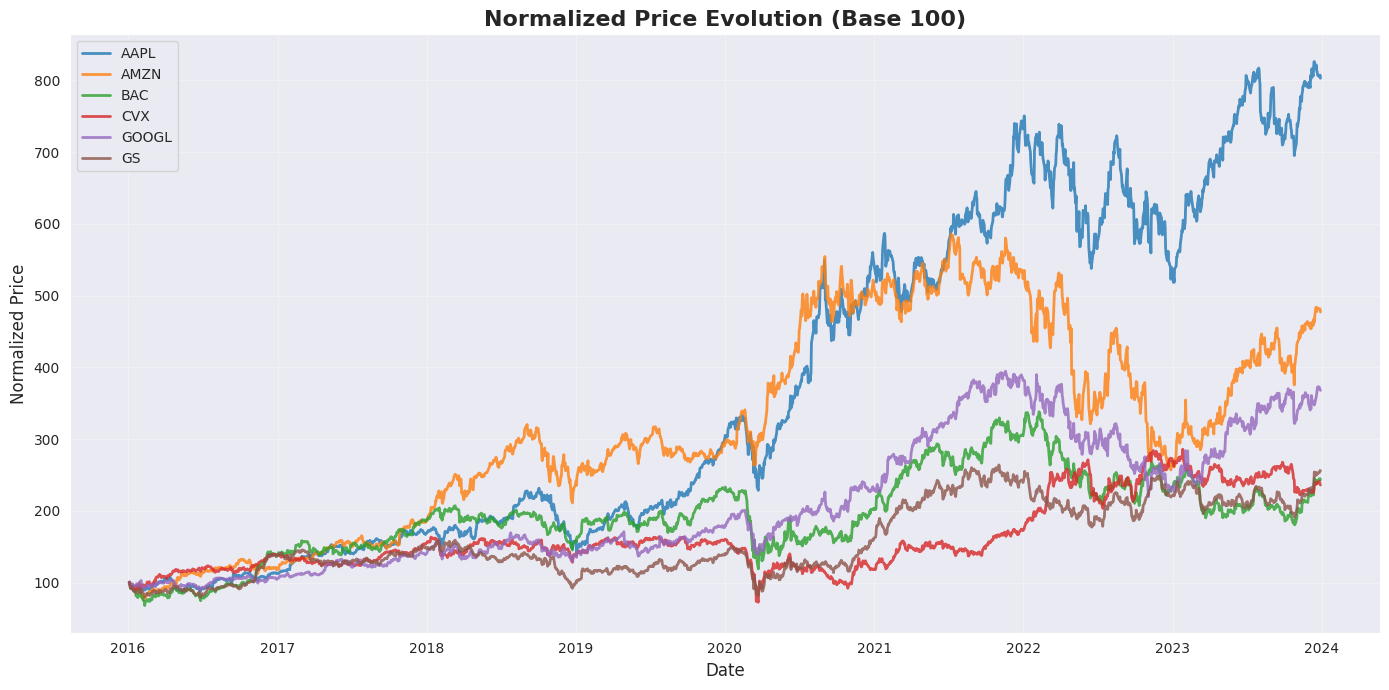

In [ ]:
def plot_price_evolution(df, tickers_to_plot=None):
    """Plot normalized closing prices for selected tickers"""
    if tickers_to_plot is None:
        # Plot first 6 tickers by default
        tickers_to_plot = df.index.get_level_values('ticker').unique()[:6]

    fig, ax = plt.subplots(figsize=(14, 7))

    for ticker in tickers_to_plot:
        ticker_data = df.xs(ticker, level='ticker')
        # Normalize to 100 at start for comparison
        normalized = (ticker_data['close'] / ticker_data['close'].iloc[0]) * 100
        ax.plot(normalized.index, normalized.values, label=ticker, linewidth=2, alpha=0.8)

    ax.set_title('Normalized Price Evolution (Base 100)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Price', fontsize=12)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot first 6 tickers
plot_price_evolution(market_prices)

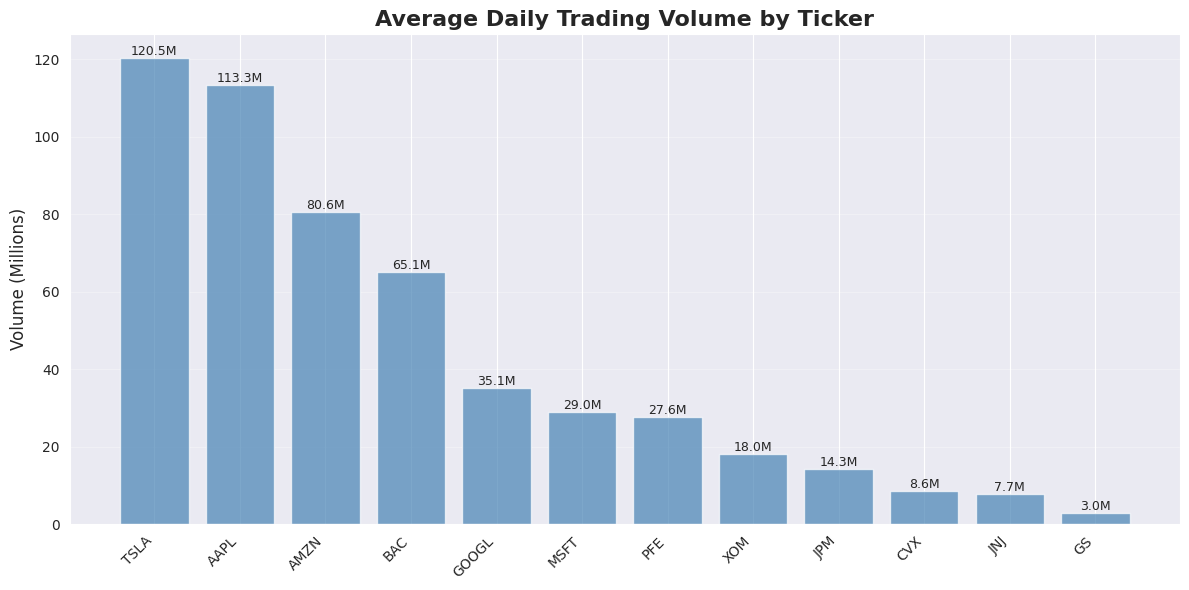

In [ ]:
def plot_volume_comparison(df):
    """Compare average daily volume across tickers"""
    avg_volume = df.groupby(level='ticker')['volume'].mean().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(avg_volume)), avg_volume.values / 1e6, color='steelblue', alpha=0.7)
    ax.set_xticks(range(len(avg_volume)))
    ax.set_xticklabels(avg_volume.index, rotation=45, ha='right')
    ax.set_title('Average Daily Trading Volume by Ticker', fontsize=16, fontweight='bold')
    ax.set_ylabel('Volume (Millions)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, avg_volume.values)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_volume_comparison(market_prices)

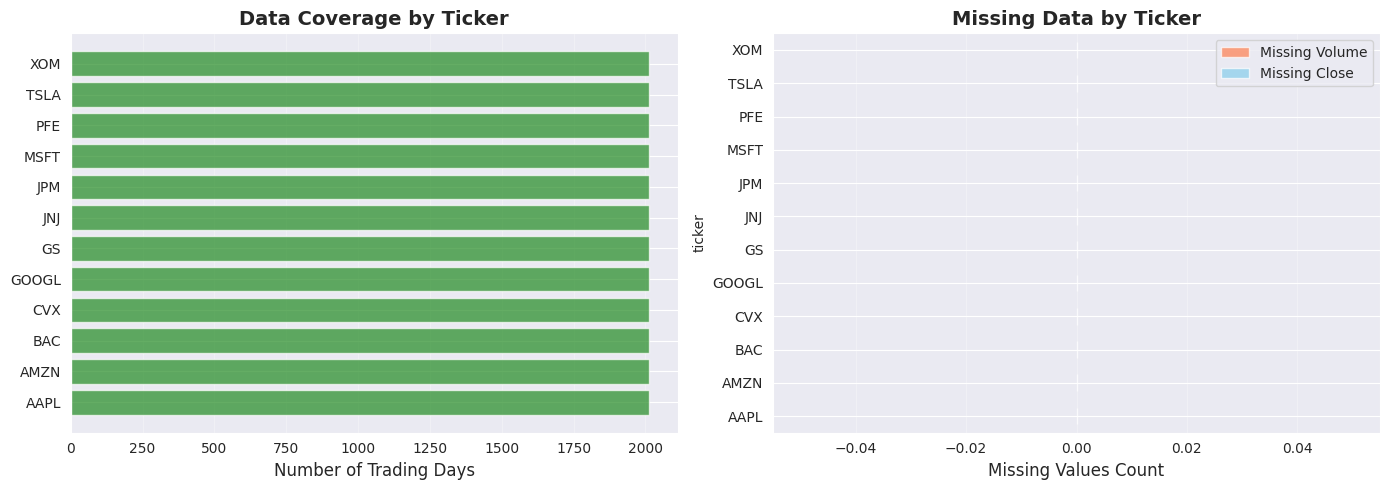

In [ ]:
def plot_data_completeness(df):
    """Visualize data completeness across tickers"""
    completeness = df.groupby(level='ticker').apply(
        lambda x: pd.Series({
            'Total Days': len(x),
            'Missing Volume': x['volume'].isna().sum(),
            'Missing Close': x['close'].isna().sum()
        })
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Days of data per ticker
    ax1.barh(completeness.index, completeness['Total Days'], color='forestgreen', alpha=0.7)
    ax1.set_xlabel('Number of Trading Days', fontsize=12)
    ax1.set_title('Data Coverage by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Missing data count
    missing_data = completeness[['Missing Volume', 'Missing Close']]
    missing_data.plot(kind='barh', ax=ax2, color=['coral', 'skyblue'], alpha=0.7)
    ax2.set_xlabel('Missing Values Count', fontsize=12)
    ax2.set_title('Missing Data by Ticker', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

plot_data_completeness(market_prices)

In [ ]:
def quality_report(df):
    """Generate data quality report"""
    print("DATA QUALITY REPORT")
    print(f"{'*'*60}")

    # Date range per ticker
    date_ranges = df.groupby(level='ticker').apply(
        lambda x: pd.Series({
            'first_date': x.index.get_level_values('Date').min(),
            'last_date': x.index.get_level_values('Date').max(),
            'total_days': len(x)
        })
    )

    print("\nPer-Ticker Summary:")
    print(date_ranges)

    # Overall statistics
    print(f"\nOverall Statistics:")
    print(f"  Total tickers: {df.index.get_level_values('ticker').nunique()}")
    print(f"  Date range: {df.index.get_level_values('Date').min()} to {df.index.get_level_values('Date').max()}")
    print(f"  Total observations: {len(df):,}")
    print(f"  Missing values: {df.isnull().sum().sum()}")

    # Price ranges (to catch anomalies)
    print(f"\nPrice Ranges (Close):")
    close_stats = df.groupby(level='ticker')['close'].agg(['min', 'max', 'mean'])
    print(close_stats)


quality_report(market_prices)

DATA QUALITY REPORT
************************************************************

Per-Ticker Summary:
       first_date  last_date  total_days
ticker                                  
AAPL   2016-01-04 2023-12-29        2012
AMZN   2016-01-04 2023-12-29        2012
BAC    2016-01-04 2023-12-29        2012
CVX    2016-01-04 2023-12-29        2012
GOOGL  2016-01-04 2023-12-29        2012
GS     2016-01-04 2023-12-29        2012
JNJ    2016-01-04 2023-12-29        2012
JPM    2016-01-04 2023-12-29        2012
MSFT   2016-01-04 2023-12-29        2012
PFE    2016-01-04 2023-12-29        2012
TSLA   2016-01-04 2023-12-29        2012
XOM    2016-01-04 2023-12-29        2012

Overall Statistics:
  Total tickers: 12
  Date range: 2016-01-04 00:00:00 to 2023-12-29 00:00:00
  Total observations: 24,144
  Missing values: 0

Price Ranges (Close):
               min         max        mean
ticker                                    
AAPL     20.604080  196.256592   88.227019
AMZN     24.103500  186.5

In [ ]:
# Define output path
output_file = DRIVE_PATH / 'market_prices.h5'

In [ ]:
# Save to HDF5 format (efficient for time-series data)
print(f"Saving to: {output_file}")
market_prices.to_hdf(
    output_file,
    key='prices',
    mode='w',
    format='table',
    complevel=9  # Maximum compression
)

print(f"✓ Data saved successfully")
print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")

Saving to: /content/drive/MyDrive/ML4T_Pipeline/market_prices.h5
✓ Data saved successfully
  File size: 0.70 MB


## 9. Verification: Reload Data

In [ ]:
# Verify we can reload the data
print("\nVerifying saved data...")
reloaded = pd.read_hdf(output_file, key='prices')

print(f"✓ Successfully reloaded data")
print(f"  Shape: {reloaded.shape}")
print(f"  Matches original: {reloaded.shape == market_prices.shape}")

print("\nSample of reloaded data:")
print(reloaded.head())


Verifying saved data...
✓ Successfully reloaded data
  Shape: (24144, 5)
  Matches original: True

Sample of reloaded data:
                       close       high        low       open     volume
Date       ticker                                                       
2016-01-04 AAPL    23.753155  23.757665  22.997834  23.135370  270597600
           AMZN    31.849501  32.886002  31.375500  32.814499  186290000
           BAC     13.196471  13.244662  13.051896  13.212535  114888000
           CVX     57.923439  58.744865  57.088977  58.366747   11397300
           GOOGL   37.687241  37.824206  37.096701  37.824206   67382000


## 10. Summary & Next Steps

In [ ]:
print("NOTEBOOK 1 COMPLETE: DATA ENGINEERING")
print(f"{'*'*60}")
print(f"\n✓ Fetched OHLCV data for {TICKERS[:3]}... (+{len(TICKERS)-3} more)")
print(f"✓ Cleaned and validated data")
print(f"✓ Saved to: {output_file}")
print(f"\n Final Dataset:")
print(f"   - Tickers: {market_prices.index.get_level_values('ticker').nunique()}")
print(f"   - Date Range: {market_prices.index.get_level_values('Date').min().date()} to {market_prices.index.get_level_values('Date').max().date()}")
print(f"   - Total Rows: {len(market_prices):,}")
print(f"   - Columns: {list(market_prices.columns)}")
print(f"\n Next: Open Notebook 2 (02_Alpha_Factory.ipynb)")
print(f"   Input: market_prices.h5")
print(f"   Output: alpha_features.h5")


NOTEBOOK 1 COMPLETE: DATA ENGINEERING
************************************************************

✓ Fetched OHLCV data for ['AAPL', 'MSFT', 'GOOGL']... (+9 more)
✓ Cleaned and validated data
✓ Saved to: /content/drive/MyDrive/ML4T_Pipeline/market_prices.h5

 Final Dataset:
   - Tickers: 12
   - Date Range: 2016-01-04 to 2023-12-29
   - Total Rows: 24,144
   - Columns: ['close', 'high', 'low', 'open', 'volume']

 Next: Open Notebook 2 (02_Alpha_Factory.ipynb)
   Input: market_prices.h5
   Output: alpha_features.h5
